## Data Collection

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [22]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
%matplotlib inline

#model building libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost

#library for resampling
from imblearn.over_sampling import SMOTE

#librares to check model performance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

#libraries to perform hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

#import library used for counting the number of observations
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)

In [3]:
#load the dataset
df_data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Feature Description
* Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
* V1 to V28: Sensitive data masked using PCA
* Amount: Transaction amount
* Class: 1 for fraudulent transactions, 0 otherwise -> TARGET feature

## Initial data analysis

In [4]:
df_data.shape

(284807, 31)

**Observation:** The dataset has 284807 rows and 31 columns

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
#check number of missing values
df_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Observation:** The dataset has no missing values

In [10]:
#Check the number of transactions with 0 amount
df_data[df_data['Amount']==0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
383,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,-0.059943,-0.508270,0.425506,0.414309,-0.698375,-1.465349,-0.119009,-0.144735,-1.332221,-1.547440,-0.133602,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
514,380.0,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,0.241979,0.144973,-0.583891,-1.595345,0.032613,0.752834,-0.094286,-0.163427,-1.111176,-1.124025,0.065979,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
534,403.0,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,0.511284,-0.178159,0.762909,1.700923,-0.133861,0.402418,0.684668,-0.609395,-0.704277,-0.720726,-0.006716,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
575,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,-0.371622,0.859741,0.372609,-1.240185,0.998391,-0.346387,-0.391679,0.348289,0.282125,1.165893,0.320450,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283719,171817.0,-0.750414,0.904175,0.996461,0.427284,1.720336,0.929256,0.794272,0.176719,-1.836261,0.233928,-0.569993,0.110682,0.784652,-0.261719,-2.370735,0.943657,-0.923311,-0.107890,0.044242,0.116340,0.050750,0.115532,-0.623995,-0.186896,0.733759,2.558151,-0.188835,0.001654,0.0,0
283782,171870.0,2.083677,-0.065811,-1.442870,0.135416,0.043035,-1.306975,0.335835,-0.371635,0.730560,-0.106473,-0.820816,0.268172,-0.431765,0.508677,0.186750,-0.518524,-0.147862,-0.728870,0.234239,-0.278137,-0.147536,-0.246599,0.194758,-0.082277,0.012887,-0.069278,-0.048995,-0.065482,0.0,0
283949,172027.0,2.132569,-0.057836,-1.724522,-0.030326,0.412146,-0.903088,0.345843,-0.348132,0.722638,-0.116179,-1.376166,0.234341,0.054018,0.394647,0.197209,-0.334269,-0.419726,-0.548358,0.492017,-0.232386,-0.188739,-0.343876,0.105024,-0.763831,0.117381,-0.027682,-0.047514,-0.071700,0.0,0
284085,172140.0,-2.210521,-1.039425,0.189704,-1.291932,3.742120,-1.665061,3.120388,-2.324089,0.364926,1.582486,1.099928,0.015128,0.071182,-1.056637,-1.611600,-0.609454,-1.876089,-0.411326,-0.556234,-0.818118,-0.286359,1.326003,-0.361764,-0.268117,1.051309,0.334629,-1.930149,-0.899888,0.0,0


In [11]:
#Check the number of transactions with negative amount
df_data[df_data['Amount']<0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


<AxesSubplot:xlabel='Class', ylabel='count'>

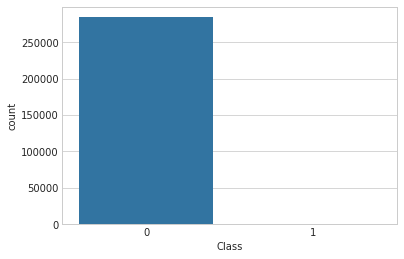

In [12]:
#Check the data distribution of Target feature
sns.countplot(x="Class", data=df_data)

In [13]:
df_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Observation:** 
* This is an **imbalanced data** as the number of '0-Legit transactions' is far greater than the number of '1-Fraud transactions' in our dataset
* 99.82% data is for '0' and remaining data is for '1'

In [16]:
df_data[df_data['Class']==0].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,1.044204,1.003112,0.945939,0.995067,0.897007,0.915060,0.844772,0.749457,0.824919,0.811733,0.769404,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,-14.741096,-4.797473,-15.144988,-5.791881,-18.392091,-4.391307,-10.115560,-17.098444,-5.366660,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,-0.532880,-0.763447,-0.402102,-0.648067,-0.422453,-0.582812,-0.465543,-0.482644,-0.497414,-0.456366,-0.211764,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,-0.091872,-0.034923,0.141679,-0.013547,0.051947,0.048294,0.067377,-0.064833,-0.002787,0.003117,-0.062646,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,0.455135,0.736362,0.619207,0.662492,0.494104,0.648842,0.523738,0.399922,0.501103,0.457499,0.132401,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,23.745136,10.002190,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


In [17]:
df_data[df_data['Class']==1].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,2.678605,4.654458,1.104518,4.278940,1.049915,3.865035,6.970618,2.899366,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,1.973397,-8.688177,-0.979117,-9.692723,-0.643539,-6.562915,-11.945057,-4.664576,-0.299423,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,5.307078,-2.974088,0.672964,-4.282821,0.609189,-1.226043,-1.341940,0.091772,1.649318,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


## Model Building

In [18]:
#Seperate dependent and independent features
X = df_data.loc[:, df_data.columns!='Class']
y = df_data['Class']

**SMOTE** is an abbreviation for Synthetic Minority Oversampling Technique.

SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [19]:
#resampling
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,y)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 284315, 1: 284315})


In [20]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

In [21]:
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (199364, 30) (199364,)
Test (85443, 30) (85443,)


### Logistic Regression Model

In [23]:
#Build Logistic Regression Model
log_model = LogisticRegression(random_state=10, n_jobs=-1)

#Apply Logistic Regression Model
log_model.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=10)

In [24]:
#make predictions on test data
y_log = log_model.predict(X_valid)

In [25]:
#Performance metrics
print('Model accuracy score: ',accuracy_score(y_valid,y_log))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_log))
print(classification_report(y_valid,y_log))

Model accuracy score:  0.9988998513628969
Confusion matrix: 
[[85260    36]
 [   58    89]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.71      0.61      0.65       147

    accuracy                           1.00     85443
   macro avg       0.86      0.80      0.83     85443
weighted avg       1.00      1.00      1.00     85443



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### XGBoost Model

In [26]:
#Define hyper-parameters
#Hyper parameter optimization
params={
   "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "min_child_weight": [1,3,5,7,9],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7]
}

#Build a model
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, n_jobs=-1, cv=5,verbose=0)

#Apply model
random_search.fit(X_train, y_train)

#Get best parameters
random_search.best_estimator_

[09:46:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=16,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [27]:
best_random = random_search.best_estimator_

#Make predictions on test data
y_xgb = best_random.predict(X_valid)

In [28]:
#Performance metrics
print('Model accuracy score: ',accuracy_score(y_valid,y_xgb))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_xgb))
print(classification_report(y_valid,y_xgb))

Model accuracy score:  0.9995201479348805
Confusion matrix: 
[[85290     6]
 [   35   112]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.95      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

[09:32:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the de

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[09:32:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[09:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be